# Step by Step Plan

Just simple simulation, goal not taken into account yet
## Assumptions:
<ol>
<li> Assume velocity at same elevation, no change in pitch </li>
<li> Allow for drift, taken into account as angle between heading direction and velocity direction </li>
<li> 360 FOV </li>
<li> Obstacles are perfect circles with variable radius </li>
<li> Intersection with obstacle defined by the minimum distance </li>
</ol>

##  Calculations 
<ol>
<li> Define FOV: 
<li> Create an array of obstacles defined by: f(x,y,r) </li> of length N
<li> Eye Unit Vectors defined in spherical coordinates f(elevation, azimuth, unit length), rotated such that it is alligned with heading direction </li>
<li> Find intersection of each pixel unit vector direction with obstacles (circumferences), take smallest distance of all intersections. Return position of intersection and distance. 
<li> Estimate Optic Flow: f(drone velocity, drone heading, unit vector pixel, distance to obstacle)
</ol>

## Define Variables:
<ol>
<li> Set position: P = (Px,Py,Pz) </li>
<li> Set velocity  V = (Vx, Vy , 0) </li>
<li> Set heading H = (Hx, Hy, 0)</li>
</ol>

## Necessary input for optic flow determination:
<ol>
<li> Velcity speed and direction, set randomly for simulation </li>
<li> Distance to object, determine by intersection point of circumference with unit vector </li>
<li> Angle between velocity direction and heading direction </li>
</ol>

# FOV




In [1]:
# Load Modules

import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Define FOV

FOV_horizontal = 360 # azimuth radians
FOV_vertical = 180 # elevation radians

# Set resolution, either restrict by amount of pixels per image, or by angular resolution

Image_width = 160 # Pixels
Image_height = 20 # Pixels

# Define angle for each pixel

def map(FOV, Image):
    FOV = FOV * np.pi /180
    array = np.arange(-FOV/2, FOV/2+FOV/Image, FOV/(Image-1))
    return array



# Spherical Coordinates

Equations for cartesiand to spherical coordinates:

$$x = cos \theta \cdot cos \psi \cdot r  $$
$$y = cos \theta \cdot sin \psi \cdot r $$
$$z = sin \theta \cdot r $$


Where $\theta$ is the elevation angle and $\psi$ the azimuth angle



In [3]:

def sphericalcoord(x,y, FOV_x, FOV_y):

    A = np.ones([y,x])
    B_hor = map(FOV_x,x)
    B_ver = map(FOV_y,y)

    C_hor = A*B_hor
    C_ver = (A.T*B_ver).T
    X= np.array(np.cos(C_hor) * np.cos(C_ver)).flatten()
    Y= np.array(np.cos(C_ver) * np.sin(C_hor)).flatten()
    Z =np.array(np.sin(C_ver)).flatten()
    pos_eye = np.vstack([X.T,Y.T,Z.T])
    print(pos_eye.shape)
    pos_eye = pos_eye.reshape(3, y,x)
    
    return pos_eye, B_hor, B_ver, X, Y , Z

FOV_pix, xx, yy, Xflat, Yflat, Zflat = sphericalcoord(Image_width, Image_height, FOV_horizontal, FOV_vertical)
FOV_pix.shape

(3, 3200)


(3, 20, 160)

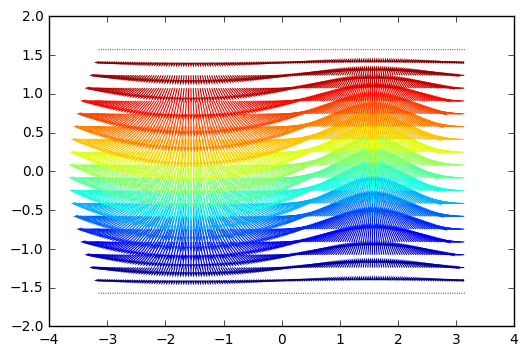

In [28]:
#xx=np.arange(0,160,1)
#yy=np.arange(0,20,1)
#zz =np.arange(-1,1,0.1)
#X,Y ,Z= np.meshgrid(xx,yy,zz)
Xmesh,Ymesh = np.meshgrid(xx,yy)
XPos = FOV_pix[0,:,:]
YPos = FOV_pix[1,:,:]
ZPos = FOV_pix[2,:,:]
q = plt.quiver(Xmesh,Ymesh, XPos, YPos, ZPos,  scale = 15)
plt.show()




# Rotation: 

Rotation matrix, assuming horizontal flight, so pure yaw about the z-axis (no roll or pitch)


$\left[ \begin{array}{ccc}
cos \alpha & -sin \alpha & 0  \\
sin \alpha & cos \alpha & 0 \\
0 & 0 & 1\\ \end{array} \right] \cdot P^{T}$

where P is the position matrix of the pixels

$\alpha$ is the angle between heading and the unit vector angle. The rotation is defined as positive in ccw direction.

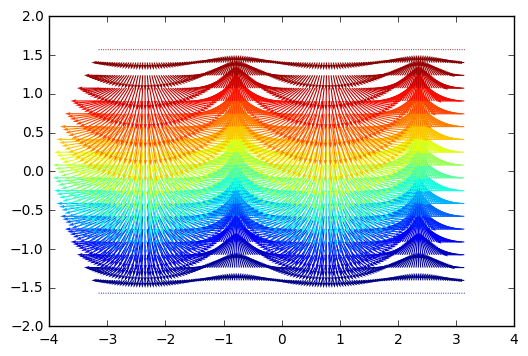

In [199]:

heading=np.pi


alpha = Xmesh.flatten() - heading

pos_rot_X = []
pos_rot_Y = []
pos_rot_Z = []
# print(len(alpha))
# t = np.arange(1, len(alpha)+1)
# print(Xmesh)
# alphaplot = plt.plot(t, (alpha), t, Xmesh.flatten())
# plt.show()
for i in range(len(alpha)):
    alpha_val = alpha[i]
    rot = np.array([np.cos(alpha_val), -np.sin(alpha_val), 0,np.sin(alpha_val), np.cos(alpha_val),0, 0,0,1])
    rot = rot.reshape(3,3)
    mat = np.array([XPos.flatten()[i], YPos.flatten()[i], ZPos.flatten()[i]])
    mat_rot = np.dot(rot, mat)

    pos_rot_X.append(mat_rot[0])
    pos_rot_Y.append(mat_rot[1])
    pos_rot_Z.append(mat_rot[2])
# print(mat_rot)
pos_rot =np.vstack([np.array(pos_rot_X).T, np.array(pos_rot_Y).T, np.array(pos_rot_Z).T])
pos_rot2 = pos_rot.reshape(3,20,160)
# a = YPos.flatten()- pos_rot_Y
# plt.plot(t, pos_rot_X, t, XPos.flatten(), t, pos_rot_Y)
# plt.show()
q = plt.quiver(Xmesh,Ymesh,pos_rot2[0,:,:] , pos_rot2[1,:,:],pos_rot2[2,:,:],  scale = 10)
plt.show()


# Intersection with obstacles

## Define obstacle:

randomize position (x,y,z) and radius



In [269]:
## source > http://paulbourke.net/geometry/circlesphere/ 
##source code: http://paulbourke.net/geometry/circlesphere/sphere_line_intersection.py

def sphere_line_intersection(l1, l2, sp, r):

    def square(f):
        return f * f
    from math import sqrt

    # l1[0],l1[1],l1[2]  P1 coordinates (point of line)
    # l2[0],l2[1],l2[2]  P2 coordinates (point of line)
    # sp[0],sp[1],sp[2], r  P3 coordinates and radius (sphere)
    # x,y,z   intersection coordinates
    #
    # This function returns a pointer array which first index indicates
    # the number of intersection point, followed by coordinate pairs.

    p1 = p2 = None

    a = square(l2[0] - l1[0]) + square(l2[1] - l1[1]) + square(l2[2] - l1[2])
    b = 2.0 * ((l2[0] - l1[0]) * (l1[0] - sp[0]) +
               (l2[1] - l1[1]) * (l1[1] - sp[1]) +
               (l2[2] - l1[2]) * (l1[2] - sp[2]))

    c = (square(sp[0]) + square(sp[1]) + square(sp[2]) + square(l1[0]) +
            square(l1[1]) + square(l1[2]) -
            2.0 * (sp[0] * l1[0] + sp[1] * l1[1] + sp[2] * l1[2]) - square(r))

    i = b * b - 4.0 * a * c

    if i < 0.0:
        pass  # no intersections
    elif i == 0.0:
        # one intersection
        p[0] = 1.0

        mu = -b / (2.0 * a)
        p1 = (l1[0] + mu * (l2[0] - l1[0]),
              l1[1] + mu * (l2[1] - l1[1]),
              l1[2] + mu * (l2[2] - l1[2]),
              )

    elif i > 0.0:
        # first intersection
        mu = (-b + sqrt(i)) / (2.0 * a)
        p1 = (l1[0] + mu * (l2[0] - l1[0]),
              l1[1] + mu * (l2[1] - l1[1]),
              l1[2] + mu * (l2[2] - l1[2]),
              )

        # second intersection
        mu = (-b - sqrt(i)) / (2.0 * a)
        p2 = (l1[0] + mu * (l2[0] - l1[0]),
              l1[1] + mu * (l2[1] - l1[1]),
              l1[2] + mu * (l2[2] - l1[2]),
              )

    return p1, p2


In [270]:
type(p1)

NoneType

In [283]:


pos_begin = [0,0,0]
spx= [5,0]
spy= [0,-10]
spz= [0,0]
rsp = [1,1]
V = [1,1,0]

#Distance
#distance = []
def distance_intersection(p1,p2):
    distance=[] 
    distance2 = []
    if p1!=None:
        #distance_p1 = np.sqrt(np.sum(np.array(p1)**2))
        distance.append(np.sqrt(np.sum(np.array(p1)**2)))
    if p2!=None:
        #distance_p2 = np.sqrt(np.sum(np.array(p2)**2)) 
        distance.append(np.sqrt(np.sum(np.array(p2)**2)) )
    if len(distance)>0:
        distance2= np.min(distance)
    return distance2

def estimateDistance(spx, spy, spz, rsp, pos_rot_X,pos_rot_Y, pos_rot_Z, pos_begin, noInter, V):
    d_store= []
    d_pos = []
    d_vec=[]
    i_loc=[]
    d_pos2 = []
    OF_pix = []
    for i in range (len(pos_rot_X)):
        for j in range(len(spx)):
            #this takes the unit vector of one pixel, and finds its intersection point with a sphere
            p1, p2 = sphere_line_intersection(pos_begin,  # begin position
                            [pos_rot_X[i], pos_rot_Y[i], pos_rot_Z[i]], #unit vector
                            [spx[j], spy[j], spz[j]], # sphere coordinates
                                              rsp[j]) # radius sphere
            # This computes the minimum distance to the sphere for one sphere
            if p1!=None or p2!=None:
                d_vec.append(distance_intersection(p1, p2))
        if d_vec== []:
            d_store.append(noInter)
            d_pos.append(l2)
            OF_pix.append(0)
        if d_vec!=[] :
            D = np.min(d_vec)
            d_store.append(np.min(d_vec))
            d_pos.append(l2)
            d_vec=[]
            OF = np.divide(V - np.multiply(np.dot(V,l2),l2), D)
            #print(OF)
            OF_pix.append(OF)
    return d_store, OF_pix



#Figure out how to plot OF, since now you have flattened it all, and stores it as a list of arrays [x,y,z] 
# if you want to plot it you might want to store it in x, y, z, seperately and then reshape etc. 
distances, OF_pix= estimateDistance(spx, spy, spz, rsp, pos_rot_X,pos_rot_Y, pos_rot_Z, pos_begin, False, V)
print(len(distances))
print(len(x))
print(len(OF_pix))
print(type(OF_pix))
OF_pix2 =np.array(OF_pix) 
OF_pix2.reshape(20,160)



3200
3200
3200
<class 'list'>


ValueError: setting an array element with a sequence.

# Computation of optic flow:

Optic flow equation :
$$ \frac{V - (\vec{V} \cdot \vec{u}) \vec{u}} {D}$$

In [284]:


V = [1,2,0]
u = [1,1,2]
#D = 0.5

np.divide(V - np.multiply(np.dot(V,u),u), D)
np.dot(V,l2)
l2
D

0.5

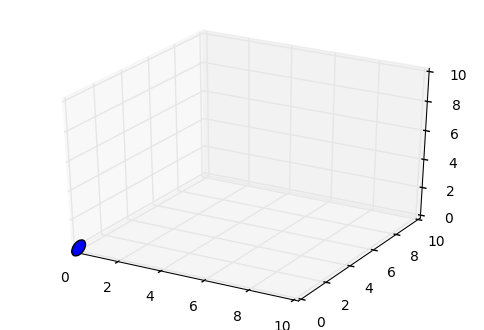

In [50]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, PathPatch
# register Axes3D class with matplotlib by importing Axes3D
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.text import TextPath
from matplotlib.transforms import Affine2D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

p = Circle((0, 0, 10), 0.5)
ax.add_patch(p)
art3d.pathpatch_2d_to_3d(p, z=0, zdir="x")


ax.set_xlim3d(0, 10)
ax.set_ylim3d(0, 10)
ax.set_zlim3d(0, 10)

plt.show()

[[0 1 2]
 [3 4 5]
 [6 7 8]] [0 1 2] [ 5 14 23]
